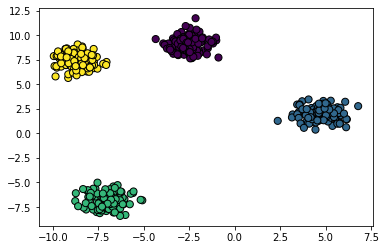

In [1]:
!pip install unionfind
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random
from unionfind import unionfind

X, y = make_blobs(
   n_samples=500, n_features=2,
   centers=4, cluster_std=0.7,
   shuffle=True, random_state=42
)


def plot_graph(X, y):
  plt.scatter(
      X[:, 0], X[:, 1],
      c=y, marker='o',
      edgecolor='black', s=50
      )
  plt.show()
plot_graph(X,y)
def euclidean_distance(a: np.array, b: np.array) -> float:
  return np.sqrt(np.sum(np.power(a - b, 2)))

# Clustering

## Clustering algorithms
 - K-means
Group points based on distance to average cluster point (centroid).
 - Hierarchical clustering
Group points based on distances between subgroups.
 - DBSCAN
Group points based on distances between subgroups.

## K-means
Algoithm:
 - Randomly select k points as centroids
 - Assign each point to the closest centroid
 - Calculate new centroids based on the mean of the points assigned to each centroid
 - Repeat until centroids do not change

The idea behind K-means clustering: a good clustering is one for which the within cluster variation (WCV) is as small as possible. The WCV for cluster k: measure the amount by which the observations within a cluster differ from each other. K-means clustering is to solve this optimization problem. K-means requires Euclidean distance, because it minimizes squared error. Without Euclidean space, the centroid can be meaningless.

The optimal number of clusters can be determined by the elbow criterion.

C:\Users\rafal\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rafal\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


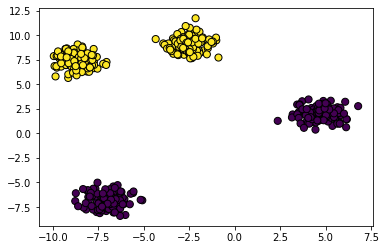

In [2]:
def kmeans(X: np.array, k: int) -> np.array:
  labels = [random.randint(0,k-1) for i in X]
  def calc_cluster_means():
    return [np.mean([X[index] for index, label in enumerate(labels) if label == i],axis=0) for i in range(k)]
  change = 1
  cluster_means = calc_cluster_means()
  while change > 0.000001:
    labels = [sorted([(euclidean_distance(value, i), index) for index, value in enumerate(cluster_means)])[0][1] for i in X]
    new_cluster_means = calc_cluster_means()
    change = np.sum([euclidean_distance(new_cluster_means[i], cluster_means[i]) for i in range(len(new_cluster_means))])
    cluster_means = new_cluster_means

  return np.array(labels)+1

plot_graph(X, kmeans(X, 4))

## Row normalization

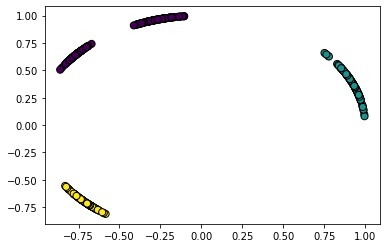

In [3]:
row_normalized_x = np.array([i/np.linalg.norm(i) for i in X])
plot_graph(row_normalized_x, kmeans(row_normalized_x, 3))

## Elbow + WVC

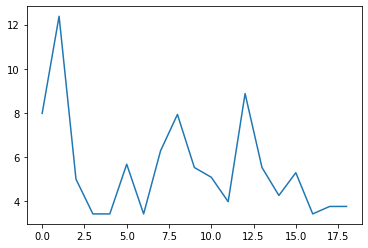

In [4]:
def WCV(X: np.array, labels: np.array, k: int) -> float:
  points_per_cluster = [[X[index] for index, label in enumerate(labels) if label == i] for i in range(k)]
  mean_per_cluster = [np.mean([X[index] for index, label in enumerate(labels) if label == i],axis=0) for i in range(k)]
  return np.sum([ np.mean([euclidean_distance(j, mean_per_cluster[i]) for j in points_per_cluster[i]]) for i in range(k) if len(points_per_cluster[i]) != 0])

wcv_values = []
for i in range(1,20):
  labels = kmeans(X, i) - 1
  wcv_values.append(WCV(X, labels, i))
plt.plot(list(range(len(wcv_values))), wcv_values)

## Agglomerative clustering
Bottom-up approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
Top-down approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

K-means requires Euclidean distance, because it minimizes squared error. Without Euclidean space, the centroid can be meaningless.

The optimal number of clusters can be determined by the elbow criterion.

## Cluster distance
 - Single-linkage clustering: distance between two clusters is the distance between the closest pair of points (minimum spanning tree)
 - Complete-linkage clustering: distance between two clusters is the distance between the farthest pair of points (maximum spanning tree)
 - Average-linkage clustering: distance between two clusters is the average distance between all pairs of points
 - Centroid-linkage clustering: distance between two clusters is the distance between the centroids of the two clusters
 - Ward-linkage clustering: distance between two clusters is the increase in within-cluster sum of squares if the two clusters were to be merged

## DBSCAN
 It is a density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

Algorithm:
 - Choose a distance threshold (epsilon) and a minimum number of points (minPts)
 - For each point, count the number of points within epsilon distance
 - If the number of points is greater than minPts, the point is a core point
 - If the number of points is less than minPts, the point is a border point
 - If the number of points is 0, the point is an outlier
 - Assign each core point to a cluster
 - Assign each border point to the cluster of its nearest core point
 - Any remaining outliers are noise

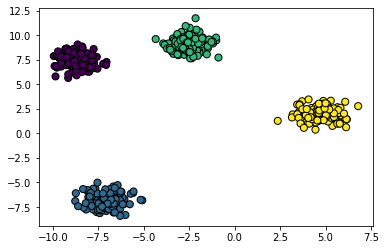

In [5]:
def dbscan(X: np.array, t: float, e: float) -> np.array:
  def in_circle_for_one_point(p_index : int, data: np.array) -> np.array:
    return [ i[1] for i in sorted([(euclidean_distance(data[p_index], vector), index) for index,vector in enumerate(data) if index != p_index]) if i[0] <= e]
  labels = []
  proximities = []
  for i in range(len(X)):
    proximity = in_circle_for_one_point(i, X)
    if len(proximity) >= t :
      labels.append(1)
    else:
      labels.append(0)
    proximities.append(proximity)
  for i in range(len(X)):
    if labels[i] == 1:
      continue;
    contains_core = False
    for j in proximities[i]:
      if labels[j]==1:
        contains_core=True
    if contains_core:
      labels[i] = 2
    else:
      labels[i] = -5
  u = unionfind(len(X))
  for i in range(len(X)):
    if labels[i] == -5:
      continue;
    for j in proximities[i]:
      if labels[j]==1:
        u.unite(i,j)
  counter = 0
  for _, group in enumerate(u.groups()):
    if len(group)==0:
      continue;
    counter+=1
    for j in group:
      labels[j] = counter
  return labels
plot_graph(X, dbscan(X, 3, 1))

## Graph based clustering
1. Construct neighborhood graph G, e.g.:
    - Connect points if their distance is below a threshold
    - Connect points if they are nearest neighbors of each other
2. Set the weight on edges based on the point-wise distance
3. Find communities on G using graph mining (later lecture)
4. Return the found communities as clusters

## Intracluster and Iterclsuter
- Let P be the set of point pairs from the same cluster
- Let Q be the set of point pairs from different clusters
- Then the average intra- and intercluster distances are:
 * Intra = sum i,j ε P dist(i,j) / |P|
 * Inter = sum i,j ε Q dist(i,j) / |Q|
- When ratio Intra/Inter is small, the clustering is considered good

## Silhouette coefficient
- Let C be the set of all clusters
- Let in ε C be the cluster the point i is part of
- Then
    * Davg ic = avg {dist(i,j) : j is in cluster c}
    * Davg iin = Davg ic with i is in cluster in
    * Dminiout = minc ε C, c ≠in Davg ic
- Silhouetter coefficient for point i is:
    * $$s(i) = \frac{Davg iin - Davg ic}{max(Davg iin, Davg ic)}$$

## Cluster Purity
- let m_ij be the number of points in cluster i that are assigned to cluster j
- d the number of clusters, t the number of classes
- We define the following measures:
  * $$N_{i} = \sum_{j=1}^t m_{ij}$$
  * $$M_{j} = \sum_{i=1}^d m_{ij}$$
  * $$P_{j} = \max_{i} m_{ij}$$
- Cluster purity is defined as:
    * $$purity = \frac{\sum_{j=1}^{k_{d}} P_{j}}{\sum_{j=1}^{k_{d}} M_{j}} $$
- GINI index is defined as:
    * $$G_{j} = 1 - \sum_{i=1}^{k_{t}} ({\frac{m_{ij}}{M_{ij}}})^2$$

## Issues with clustering
- Centroid-based
  * Gets stuck in local minima
  * Initialization can be problematic
  * How to handle streaming data?
  * Cannot handle non-spherical clusters
- Hierarchical and Density/Graph-based
  * Required computing distance matrix which is very expensive..
  *  See lecture of locality sensitive hashing for solutions!
  * Streaming data?

## K-Means++
1. Assign first centroid c to point uniformly at random
2. Add c to C
3. For each datapoint x ε X
  * Compute d(x) = minc ε C distance(x,c)
4. Assign next centroid c to a random point
  * with probability proportional to d(x)2, e.g.,P(x) = d(x)^2 / sum_y d(x)^2
5. If less than k centroids are assigned, goto 3
6. Else, proceed with standard k-means

## CURE
1. Assign first centroid c to point uniformly at random
2. Add c to C
3. For each datapoint x ε X
• Compute d(x) = minc ε C distance(x,c)
4. Assign next centroid c to a random point
• with probability proportional to d(x)2, e.g.,P(x) = d(x)^2 / sum_y d(x)^2
5. If less than k centroids are assigned, goto 3
6. Else, proceed with standard k-means

In [6]:
# data_samples = sample_m_data_points_from_the_dataset()
# k_sample_clusters = cluster(data_samples, k)
# cure_clusters = []
# foreach cluster in k_sample_clusters:
#     points = find_k_most_representative_points(cluster)
#     centroid = find_centroid(points)
#     foreach point in points:
#         move point x% towards the centroid
#     add cure_cluster(points) to cure_clusters
#
# foreach dp in remaining data:
#     assign dp to cure_cluster of the closest representative point
def cure(data, k, s, alpha):
    # Select a random subset of alpha data points as cluster representatives
    num_reps = int(alpha * len(data))
    rep_indices = np.random.choice(len(data), num_reps, replace=False)
    reps = data[rep_indices]

    # Initialize the cluster assignments
    cluster_assignment = np.zeros(len(data), dtype=int)

    # Repeat until all data points have been assigned to a cluster
    while np.any(cluster_assignment == 0):
        # Compute the pairwise distances between all representative points
        rep_distances = np.linalg.norm(reps[:, np.newaxis] - reps, axis=2)

        # Find the closest s - 1 representative points to each representative point
        closest_reps = np.argpartition(rep_distances, s-1, axis=1)[:, :s-1]

        # Compute the new cluster representatives as the centroids of the closest s - 1 representatives
        new_reps = np.array([data[closest_reps[i]].mean(axis=0) for i in range(len(reps))])

        # Assign each data point to the closest new representative
        distances = np.linalg.norm(data[:, np.newaxis] - new_reps, axis=2)
        cluster_assignment = np.argmin(distances, axis=1)

        # Reassign any unassigned data points to the closest representative
        unassigned_indices = np.where(cluster_assignment == 0)[0]
        if len(unassigned_indices) > 0:
            distances = np.linalg.norm(data[unassigned_indices, np.newaxis] - reps, axis=2)
            closest_rep_indices = np.argmin(distances, axis=1)
            cluster_assignment[unassigned_indices] = closest_rep_indices + 1

        # Update the representative points
        reps = np.array([data[cluster_assignment == i].mean(axis=0) for i in range(1, num_reps+1)])

        # Reduce the number of representative points to k
        if len(reps) > k:
            distances = np.linalg.norm(reps[:, np.newaxis] - reps, axis=2)
            merge_indices = np.unravel_index(np.argmin(distances), distances.shape)
            reps[merge_indices[0]] = (reps[merge_indices[0]] + reps[merge_indices[1]]) / 2
            reps = np.delete(reps, merge_indices[1], axis=0)
            num_reps -= 1

    return cluster_assignment

## DFR (Bradley, Fayyad, Reina)
- Aims to minimize time and space required by k-means
- Assigns points to cluster one-by-one, but discards many
- Points can be assigned to three sets:
• Discard set – assigned to a pre-existing cluster
• Compressed set – mini-clusters (a clustering of remaining points)
• Retained set – outliers, points that do not belong to any cluster
- Only the retained set is stored in memory, for the other sets, we maintain sufficient statistics
- For a cluster in BFR, we only require the following
    1. N – the number of data points in the cluster
    2. SUM – a vector containing with sums of all feature values
    3. SUMSQ – a vector with sums of squared feature values
- Using these we can
    1. Keep track of the centroid (mean) of the cluster
    2. Compute a threshold for cluster membership
- For each batch of points:
    - If a point is in discard set, update statistics and discard
    - For remaining points
        - Use standard clustering to obtain miniclusters
        - Compute statistics for miniclusters, discard points
        - Keep unclustered points in retained set
    - Merge miniclusters and retained points with older miniclusters,
    update their statistics